# Session 13

## Cloning the repo

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Github/ERA-v1

/content/drive/MyDrive/Github/ERA-v1


In [ ]:
! git config --global user.email "me18b059@smail.iitm.ac.in"
! git config --global  pull.ff true
! git stash push --include-untracked
! git stash drop
! git pull

In [4]:
%cd S13/

/content/drive/MyDrive/Github/ERA-v1/S12


# CIFAR-10 dataset classification

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class.

# Importing basic dependencies

In [ ]:
!pip install torchmetrics
!pip install torch_lr_finder
!pip install pytorch_lightning

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# del model
import torch
from Utilities.model import YOLOv3
import torch.nn.functional as F
from torchsummary import summary
from Utilities import config

# Model Initialization & Summary

In [3]:
model = YOLOv3(num_classes=config.NUM_CLASSES)

summary(model, input_size=(3, config.IMAGE_SIZE, config.IMAGE_SIZE))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 416, 416]             864
       BatchNorm2d-2         [-1, 32, 416, 416]              64
         LeakyReLU-3         [-1, 32, 416, 416]               0
          CNNBlock-4         [-1, 32, 416, 416]               0
            Conv2d-5         [-1, 64, 208, 208]          18,432
       BatchNorm2d-6         [-1, 64, 208, 208]             128
         LeakyReLU-7         [-1, 64, 208, 208]               0
          CNNBlock-8         [-1, 64, 208, 208]               0
            Conv2d-9         [-1, 32, 208, 208]           2,048
      BatchNorm2d-10         [-1, 32, 208, 208]              64
        LeakyReLU-11         [-1, 32, 208, 208]               0
         CNNBlock-12         [-1, 32, 208, 208]               0
           Conv2d-13         [-1, 64, 208, 208]          18,432
      BatchNorm2d-14         [-1, 64, 2

# Dataset & Dataloaders

In [4]:
from Utilities.dataset import YOLODataModule

data_module = YOLODataModule(train_csv_path=config.DATASET + '/train.csv', 
                             test_csv_path=config.DATASET + "/test.csv")

In [5]:
# Call the setup() method before train_dataloader()
data_module.setup(stage=None)

# Now you can call train_dataloader()
train_loader = data_module.train_dataloader()

# Training

In [8]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from Utilities.callbacks import PlotTestExamplesCallback, MAPCallback, CheckClassAccuracyCallback, LearningRateMonitor

trainer = pl.Trainer(
    max_epochs=40,
    accelerator=config.DEVICE,
    callbacks=[
        ModelCheckpoint(
            dirpath=config.CHECKPOINT_PATH,
            verbose=True,
        ),
        PlotTestExamplesCallback(every_n_epochs=3),
        CheckClassAccuracyCallback(train_every_n_epochs=1, test_every_n_epochs=3),
        MAPCallback(every_n_epochs=10),
        LearningRateMonitor(),
    ],
    default_root_dir='Store/',
)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/madhurjindal/WorkProjects/ERA-v1/ERAenv/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


In [13]:
from pytorch_lightning.tuner import Tuner

tuner = Tuner(trainer=trainer)

# Run learning rate finder
lr_finder = tuner.lr_find(model,datamodule=data_module, min_lr=1e-4, max_lr=1, )


/Users/madhurjindal/WorkProjects/ERA-v1/ERAenv/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:68: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
/Users/madhurjindal/WorkProjects/ERA-v1/ERAenv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/madhurjindal/WorkProjects/ERA-v1/ERAenv/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Se

EPOCH: 0, Loss: 50.499759674072266


EPOCH: 1, Loss: 49.0426025390625


EPOCH: 2, Loss: 49.41123580932617


EPOCH: 3, Loss: 46.70933151245117


EPOCH: 4, Loss: 44.731468200683594


EPOCH: 5, Loss: 47.09819793701172


EPOCH: 6, Loss: 46.440181732177734


EPOCH: 7, Loss: 41.71978759765625


EPOCH: 8, Loss: 38.1815185546875


EPOCH: 9, Loss: 36.544830322265625


EPOCH: 10, Loss: 37.16646194458008


EPOCH: 11, Loss: 41.42087936401367


EPOCH: 12, Loss: 40.79343795776367


EPOCH: 13, Loss: 37.325462341308594


EPOCH: 14, Loss: 32.53284454345703


EPOCH: 15, Loss: 30.235607147216797


EPOCH: 16, Loss: 28.984479904174805


EPOCH: 17, Loss: 27.180706024169922


EPOCH: 18, Loss: 30.967721939086914


EPOCH: 19, Loss: 24.144424438476562


EPOCH: 20, Loss: 25.812591552734375


EPOCH: 21, Loss: 23.40015983581543


EPOCH: 22, Loss: 22.925323486328125


EPOCH: 23, Loss: 21.421560287475586


EPOCH: 24, Loss: 20.45366859436035


EPOCH: 25, Loss: 18.31435775756836


EPOCH: 26, Loss: 18.9155330657959


EPOCH: 27, Loss: 18.526336669921875


EPOCH: 28, Loss: 15.461710929870605


EPOCH: 29, Loss: 15.584818840026855


EPOCH: 30, Loss: 15.719563484191895


EPOCH: 31, Loss: 14.030838966369629


EPOCH: 32, Loss: 12.65446949005127


EPOCH: 33, Loss: 13.68079948425293


EPOCH: 34, Loss: 11.809334754943848


EPOCH: 35, Loss: 12.144990921020508


EPOCH: 36, Loss: 12.364418029785156


EPOCH: 37, Loss: 11.372212409973145


EPOCH: 38, Loss: 9.173650741577148


`Trainer.fit` stopped: `max_epochs=40` reached.
LR finder stopped early after 40 steps due to diverging loss.
Finding best initial lr:  40%|████      | 40/100 [04:12<06:18,  6.30s/it]
Learning rate set to 0.00047863009232263843
Restoring states from the checkpoint path at Store/.lr_find_e5b84244-39df-444c-ae88-7c5e21d05d22.ckpt
Restored all states from the checkpoint at Store/.lr_find_e5b84244-39df-444c-ae88-7c5e21d05d22.ckpt


EPOCH: 39, Loss: 9.91149616241455


new_lr=0.00047863009232263843


/var/folders/_p/l4cqby956gg3nff31ksd975m0000gn/T/ipykernel_23571/494361915.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


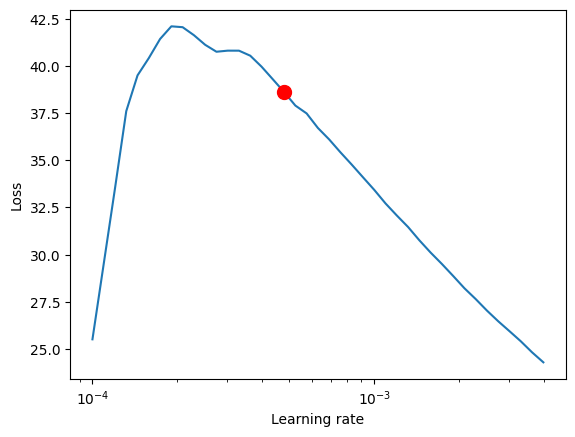

In [14]:
# Results can be found in
# print(lr_finder.results)

# Plot with
fig = lr_finder.plot(suggest=True)
fig.show()

# Pick point based on plot, or get suggestion
new_lr = lr_finder.suggestion()
print(f"{new_lr=}")

# Testing & Evaluation

/Users/madhurjindal/WorkProjects/ERA-v1/ERAenv/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:68: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
/Users/madhurjindal/WorkProjects/ERA-v1/ERAenv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:615: UserWarning: Checkpoint directory /Users/madhurjindal/WorkProjects/ERA-v1/S13/Store/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name   | Type       | Params
--------------------------------------
0 | layers | ModuleList | 61.6 M
--------------------------------------
61.6 M    Trainable params
0         Non-trainable params
61.6 M    Total params
246.506   Total estimated model params size (MB)
/Users/madhurjindal/WorkProjects/ERA-v1/ERAenv/lib/python3.10/site

Epoch 10: 100%|██████████| 1/1 [00:05<00:00,  5.45s/it, v_num=7, train_loss_step=34.50]+++ TRAIN ACCURACIES


100%|██████████| 1/1 [00:01<00:00,  1.78s/it]

Class accuracy is: 23.076923%
No obj accuracy is: 0.000000%
Obj accuracy is: 100.000000%
Epoch 10: 100%|██████████| 1/1 [00:07<00:00,  7.24s/it, v_num=7, train_loss_step=34.50, train_loss_epoch=34.50]

EPOCH: 10, Loss: 34.54931640625
Epoch 11: 100%|██████████| 1/1 [00:05<00:00,  5.46s/it, v_num=7, train_loss_step=34.30, train_loss_epoch=34.50]

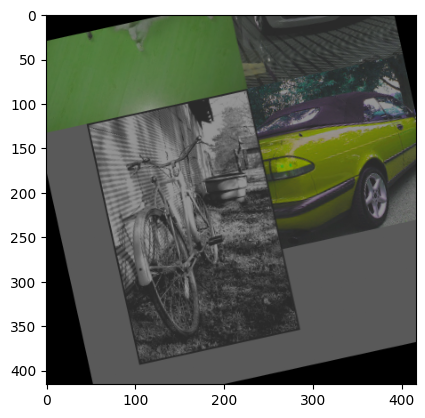

+++ TRAIN ACCURACIES


100%|██████████| 1/1 [00:01<00:00,  1.71s/it]


Class accuracy is: 40.170940%
No obj accuracy is: 0.000000%
Obj accuracy is: 100.000000%
+++ TEST ACCURACIES


100%|██████████| 1/1 [00:03<00:00,  3.16s/it]

Class accuracy is: 18.850574%
No obj accuracy is: 0.000000%
Obj accuracy is: 100.000000%
Epoch 11: 100%|██████████| 1/1 [00:12<00:00, 12.16s/it, v_num=7, train_loss_step=34.30, train_loss_epoch=34.30]

EPOCH: 11, Loss: 34.316490173339844
Epoch 12: 100%|██████████| 1/1 [00:05<00:00,  5.11s/it, v_num=7, train_loss_step=31.50, train_loss_epoch=34.30]+++ TRAIN ACCURACIES


100%|██████████| 1/1 [00:01<00:00,  1.76s/it]

Class accuracy is: 33.974358%
No obj accuracy is: 0.000000%
Obj accuracy is: 100.000000%
Epoch 12: 100%|██████████| 1/1 [00:06<00:00,  6.88s/it, v_num=7, train_loss_step=31.50, train_loss_epoch=31.50]

EPOCH: 12, Loss: 31.535200119018555
Epoch 13: 100%|██████████| 1/1 [00:05<00:00,  5.53s/it, v_num=7, train_loss_step=29.40, train_loss_epoch=31.50]+++ TRAIN ACCURACIES


100%|██████████| 1/1 [00:01<00:00,  1.68s/it]

Class accuracy is: 33.333336%
No obj accuracy is: 0.000000%
Obj accuracy is: 100.000000%
Epoch 13: 100%|██████████| 1/1 [00:07<00:00,  7.22s/it, v_num=7, train_loss_step=29.40, train_loss_epoch=29.40]

EPOCH: 13, Loss: 29.350830078125
Epoch 14: 100%|██████████| 1/1 [00:04<00:00,  4.56s/it, v_num=7, train_loss_step=27.50, train_loss_epoch=29.40]

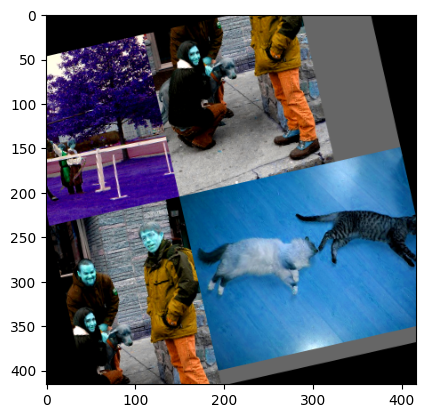

+++ TRAIN ACCURACIES


100%|██████████| 1/1 [00:01<00:00,  1.77s/it]


Class accuracy is: 24.000000%
No obj accuracy is: 4.581087%
Obj accuracy is: 66.666672%
+++ TEST ACCURACIES


100%|██████████| 1/1 [00:03<00:00,  3.18s/it]

Class accuracy is: 14.925373%
No obj accuracy is: 4.569304%
Obj accuracy is: 68.159203%
Epoch 14: 100%|██████████| 1/1 [00:11<00:00, 11.53s/it, v_num=7, train_loss_step=27.50, train_loss_epoch=27.50]

EPOCH: 14, Loss: 27.489208221435547
Epoch 15: 100%|██████████| 1/1 [00:04<00:00,  4.50s/it, v_num=7, train_loss_step=32.70, train_loss_epoch=27.50]+++ TRAIN ACCURACIES


100%|██████████| 1/1 [00:01<00:00,  1.68s/it]

Class accuracy is: 33.333336%
No obj accuracy is: 4.714483%
Obj accuracy is: 66.666672%
Epoch 15: 100%|██████████| 1/1 [00:06<00:00,  6.18s/it, v_num=7, train_loss_step=32.70, train_loss_epoch=32.70]

EPOCH: 15, Loss: 32.72315216064453
Epoch 16: 100%|██████████| 1/1 [00:04<00:00,  4.55s/it, v_num=7, train_loss_step=27.00, train_loss_epoch=32.70]+++ TRAIN ACCURACIES


100%|██████████| 1/1 [00:01<00:00,  1.72s/it]

Class accuracy is: 26.415094%
No obj accuracy is: 4.699791%
Obj accuracy is: 66.666672%
Epoch 16: 100%|██████████| 1/1 [00:06<00:00,  6.27s/it, v_num=7, train_loss_step=27.00, train_loss_epoch=27.00]

EPOCH: 16, Loss: 26.96109390258789
Epoch 17: 100%|██████████| 1/1 [00:04<00:00,  4.50s/it, v_num=7, train_loss_step=23.90, train_loss_epoch=27.00]

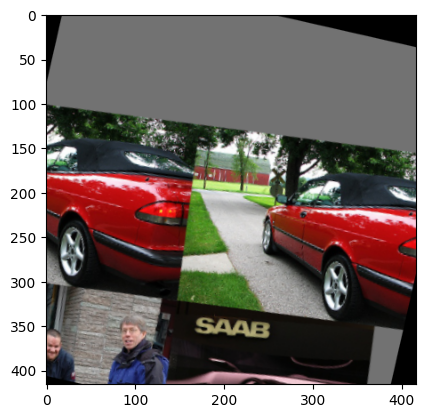

+++ TRAIN ACCURACIES


100%|██████████| 1/1 [00:01<00:00,  1.74s/it]


Class accuracy is: 19.871796%
No obj accuracy is: 4.694413%
Obj accuracy is: 66.666672%
+++ TEST ACCURACIES


100%|██████████| 1/1 [00:03<00:00,  3.24s/it]

Class accuracy is: 10.591900%
No obj accuracy is: 4.709239%
Obj accuracy is: 66.666672%
Epoch 17: 100%|██████████| 1/1 [00:11<00:00, 11.79s/it, v_num=7, train_loss_step=23.90, train_loss_epoch=23.90]

EPOCH: 17, Loss: 23.92385482788086
Epoch 18: 100%|██████████| 1/1 [00:05<00:00,  5.38s/it, v_num=7, train_loss_step=21.70, train_loss_epoch=23.90]+++ TRAIN ACCURACIES


100%|██████████| 1/1 [00:01<00:00,  1.68s/it]

Class accuracy is: 32.624115%
No obj accuracy is: 4.928545%
Obj accuracy is: 66.666672%
Epoch 18: 100%|██████████| 1/1 [00:07<00:00,  7.07s/it, v_num=7, train_loss_step=21.70, train_loss_epoch=21.70]

EPOCH: 18, Loss: 21.702484130859375
Epoch 19: 100%|██████████| 1/1 [00:05<00:00,  5.40s/it, v_num=7, train_loss_step=20.80, train_loss_epoch=21.70]+++ TRAIN ACCURACIES


100%|██████████| 1/1 [00:01<00:00,  1.73s/it]


Class accuracy is: 26.666668%
No obj accuracy is: 3.426766%
Obj accuracy is: 72.592590%


In [18]:
trainer.fit(model=model, datamodule=data_module)

### Git Push

In [22]:
! git remote set-url origin git@github.com:Madhur-1/ERA-v1.git
! git add .
# ! git commit -m "S12 commit 92.31%"
! git push

Host key verification failed.
fatal: Could not read from remote repository.

Please make sure you have the correct access rights
and the repository exists.
